# <div style='font-size:105%; font-family:Arial'> Daily Installation Forecast via MMM <span style="float:right;"> V. Ganci </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> <hr style="border-top: 2px solid black; margin-top: 2px; margin-bottom: 0px;"> </div>

Table of contents:
<ul>
    <li style='margin-bottom: 5px'><a href="#intro"> 0. Intro & Libraries </a></li>
    <li style='margin-bottom: 5px'><a href="#data"> 1. Data Overview </a></li>
    <li style='margin-bottom: 5px'><a href="#eda"> 2. Feature Engineering & EDA </a></li>
    <li style='margin-bottom: 5px'><a href="#model"> 3. Modeling </a></li>
    <li style='margin-bottom: 5px'><a href="#forecast"> 4. Final Model & Forecasting </a></li>
    <li style='margin-bottom: 5px'><a href="#end"> 5. Results & Next Steps </a></li>
</ul>

<a id='intro'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Intro & Libraries   <span style="float:right;"> 0. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

A company has been running a paid marketing campaign for a client in the media industry for about 2 years to increase the daily installations number of their app. The company allocates funds for promoting the app on Facebook and on Google for a certain timespan. The goal of this notebook is to understand the true impact of the campaign on the app daily installations.

After data cleaning, feature engineering and the EDA phase, to predicting the daily installations number, I train a multivariate linear regression model through the available predictors and newly created ones. A seasonality patter analysis is conducted on the data through a LOESS analysis. The seasonality pattern is then included in the final model.

I conclude the notebook with a summary of the results and the possible next steps.

In [1]:
# Importing libraries

import os

import math
import numpy as np
import pandas as pd
import datetime as dt
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(6,2)}, style='whitegrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import pickle

# Filtering out FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Create Results folder if not existing

if not os.path.exists(os.path.join('.', 'Results')):
    os.makedirs(os.path.join('.', 'Results'))

<a id='data'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Data Overview  <span style="float:right;"> 1. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

In [3]:
# Load dataset

df_0 = pd.read_csv('Data/case-data-2024.csv', delimiter=';')
df = df_0.copy()

In [4]:
# Checking for duplicates

print('The dataset has', df.duplicated().sum(), 'duplicate rows.\n')

The dataset has 0 duplicate rows.



In [5]:
df.head(2)

,date,installs,spend_facebook,spend_google,promotion
0,1-1-2019,1667,1406.0,NaN,Yes
1,1-2-2019,1889,1197.0,NaN,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            790 non-null    object 
 1   installs        790 non-null    int64  
 2   spend_facebook  247 non-null    float64
 3   spend_google    162 non-null    float64
 4   promotion       158 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 31.0+ KB


I assume here that the missing values in the spend_fb, spend_ggl, and promotion, are days in which the money spent on fb and ggl is 0, and that the promotion is not taking place (labeled as 0)

In [7]:
# Filling missing values with 0

df = df.fillna(0)

# Transforming the promotion variable into a binary numeric one

df['promotion'] = df['promotion'].apply(lambda x: 1 if x == 'Yes' else 0)

In [8]:
df.describe()

,installs,spend_facebook,spend_google,promotion
count,790.000000,790.000000,790.000000,790.000000
mean,1252.686076,242.307595,234.312658,0.200000
std,885.162724,396.058160,545.543010,0.400253
min,300.000000,0.000000,0.000000,0.000000
25%,439.250000,0.000000,0.000000,0.000000
50%,1153.500000,0.000000,0.000000,0.000000
75%,1724.000000,526.750000,0.000000,0.000000
max,5636.000000,1475.000000,2195.000000,1.000000


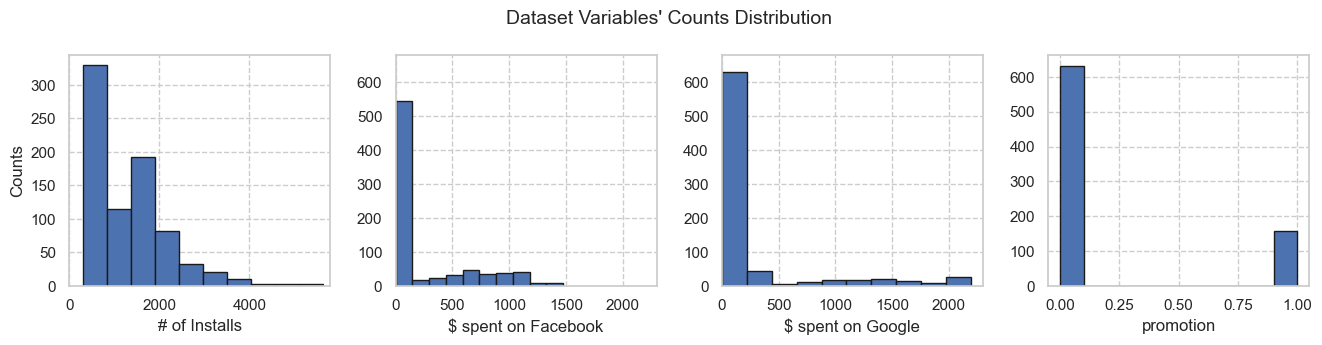

In [9]:
fig1, ax = plt.subplots(1, 4, figsize = (16,3))
plt.subplots_adjust(wspace=0.25)

fig1.suptitle("Dataset Variables' Counts Distribution", y=1.03, fontsize=14)

ax[0].hist(df.installs, color='C0', edgecolor='k', zorder=2)
ax[0].set(xlabel='# of Installs', ylabel='Counts')
ax[0].axis([-0.5,5800,0,345])

ax[1].hist(df['spend_facebook'], color='C0', edgecolor='k', zorder=2)
ax[1].set(xlabel='$ spent on Facebook', ylabel='')
ax[1].axis([-0.5,2300,0,680])

ax[2].hist(df['spend_google'], color='C0', edgecolor='k', zorder=2)
ax[2].set(xlabel='$ spent on Google', ylabel='')
ax[2].axis([-0.5,2300,0,680])

ax[3].hist(df.promotion, color='C0', edgecolor='k', zorder=2)
ax[3].set(xlabel='promotion', ylabel='')

for x in range(4):
    ax[x].grid(ls='--', zorder=0)

plt.show()

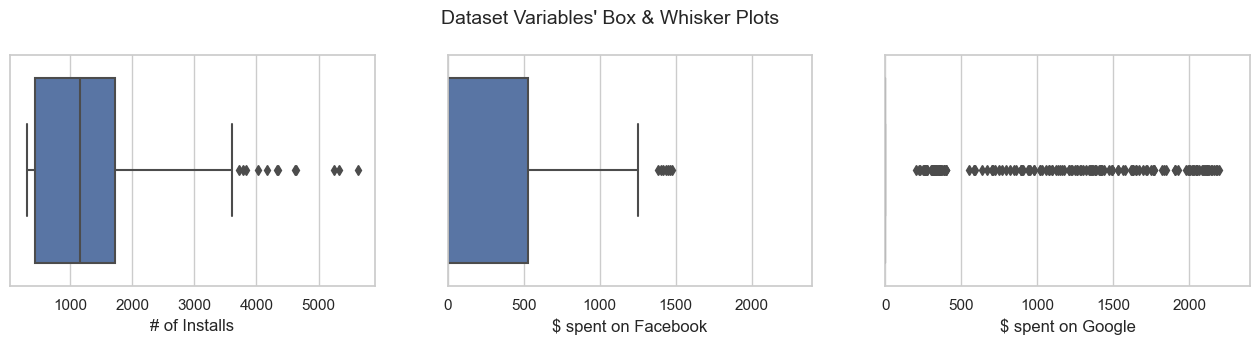

In [10]:
fig2, ax = plt.subplots(1, 3, figsize = (16,3))
plt.subplots_adjust(wspace=0.2)

fig2.suptitle("Dataset Variables' Box & Whisker Plots", y=1.03, fontsize=14)

sns.boxplot(df.installs, orient='h', ax=ax[0])
ax[0].set(xlabel='# of Installs', ylabel='')

sns.boxplot(df['spend_facebook'], orient='h', ax=ax[1])
ax[1].set(xlabel='$ spent on Facebook', ylabel='')
ax[1].axis([-0.5,2400,0.5,-0.5])

sns.boxplot(df['spend_google'], orient='h', ax=ax[2])
ax[2].set(xlabel='$ spent on Google', ylabel='')
ax[2].axis([-0.5,2400,0.5,-0.5])

for x in range(3):
    ax[x].set_yticks([])
    ax[x].set_yticklabels([])

plt.show()

The variable distributions are significantly skewed due to the presence of numerous instances with value equal to zero. The promotion feature is unbalanced towards null values.

In [11]:
# Convert dates to pandas datetime format

df['date'] = pd.to_datetime(df['date'], format='%m-%d-%Y')

# Sorting data by 'date'

df.sort_values(by=['date'], inplace=True, ascending=True)

In [12]:
# Checking time spanned by the dataset

print('Earliest sale registered:', df.date.min())
print('Latest sale registered:', df.date.max())

Earliest sale registered: 2019-01-01 00:00:00
Latest sale registered: 2021-02-28 00:00:00


In [13]:
# Checking if there are time gaps

full_date_range = pd.date_range(start=df.date.min(), end=df.date.max())

missing_dates = full_date_range[~full_date_range.isin(df.date)]

print('Number of missing dates:', len(missing_dates))

Number of missing dates: 0


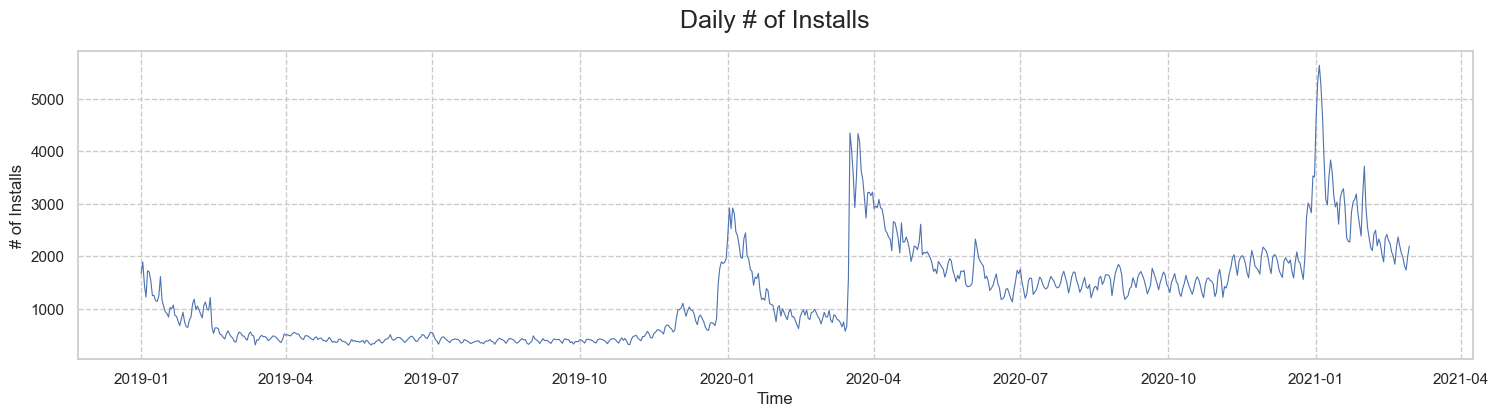

In [14]:
fig3, ax = plt.subplots(figsize = (18,4))

ax.set_title('Daily # of Installs', y=1.05, fontsize=18)

ax.plot(df.date, df.installs, lw=0.8)

ax.set(xlabel='Time', ylabel='# of Installs')
ax.grid(ls='--')

plt.show()

<a id='eda'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Feature Engineering & EDA <span style="float:right;"> 2. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

In [15]:
# Creating day, weekday, and weekend columns

df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
#df.head()

In [16]:
# Creating binary predictors

df['fb_bin'] = df['spend_facebook'].apply(lambda x: 1 if x > 0 else 0)
df['ggl_bin'] = df['spend_google'].apply(lambda x: 1 if x > 0 else 0)
#df.head()

In [17]:
# Creating cross variables

df['fb_prom'] = df['spend_facebook'] * df['promotion']
df['ggl_prom'] = df['spend_google'] * df['promotion']
df['fb_ggl_prom'] = df['spend_facebook'] * df['spend_google'] * df['promotion']
#df.head()

In [18]:
# Creating lagged predictors

df['fb_lag1'] = df['spend_facebook'].shift(1)
df['fb_lag2'] = df['spend_facebook'].shift(2)
df['fb_lag3'] = df['spend_facebook'].shift(3)
df['fb_lag4'] = df['spend_facebook'].shift(4)

df['ggl_lag1'] = df['spend_google'].shift(1)
df['ggl_lag2'] = df['spend_google'].shift(2)
df['ggl_lag3'] = df['spend_google'].shift(3)
df['ggl_lag4'] = df['spend_google'].shift(4)

#df.head()

In [19]:
# Creating lagged target features

df['installs_lag1'] = df['installs'].shift(1)
df['installs_lag2'] = df['installs'].shift(2)
df['installs_lag3'] = df['installs'].shift(3)
df['installs_lag4'] = df['installs'].shift(4)
#df.head()

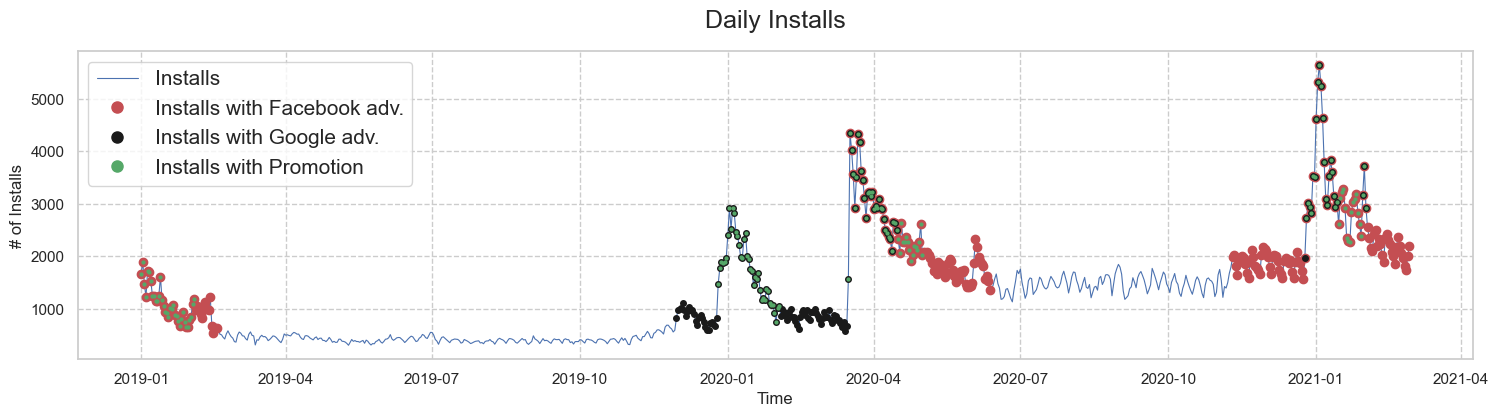

In [20]:
fig4, ax = plt.subplots(figsize = (18,4))

ax.set_title('Daily Installs', y=1.05, fontsize=18)

ax.plot(df.date, df.installs, lw=0.8, label='Installs')

ax.plot(df[df['spend_facebook'] > 0].date, df[df['spend_facebook'] > 0].installs, ls='none', marker='o', ms=6, color='r', label='Installs with Facebook adv.')
ax.plot(df[df['spend_google'] > 0].date, df[df['spend_google'] > 0].installs, ls='none', marker='o', ms=4, color='k', label='Installs with Google adv.')
ax.plot(df[df['promotion'] == 1].date, df[df['promotion'] == 1].installs, ls='none', marker='o', ms=2, color='g', label='Installs with Promotion')

ax.set(xlabel='Time', ylabel='# of Installs')
ax.grid(ls='--')
legend = ax.legend(fontsize=15)

for line in legend.get_lines():
    line.set_markersize(8)

plt.show()

We note that when the promotion takes place, the # of installations greatly increases. Follows a slow decay and a stabilization to a # of installations larger than the one present before the promotion took place.

I am going to cut now the dataset, as data before 2019-10 do not add important information since no promotion is taking place.

In [21]:
# Cutting the dataset

df_2019_11 = df[df['date'] >= '2019-11-01'].copy()
df_2019_11.reset_index(drop=True, inplace=True)
df_2019_11.dropna(axis = 0, inplace = True)
#df_2019_11.head()

In [22]:
# Creating dummy time feature

df_2019_11['n_day'] = np.arange(1,len(df_2019_11.index)+1)
df_2019_11.insert(1, 'n_day', df_2019_11.pop('n_day'))
#df_2019_11.head()

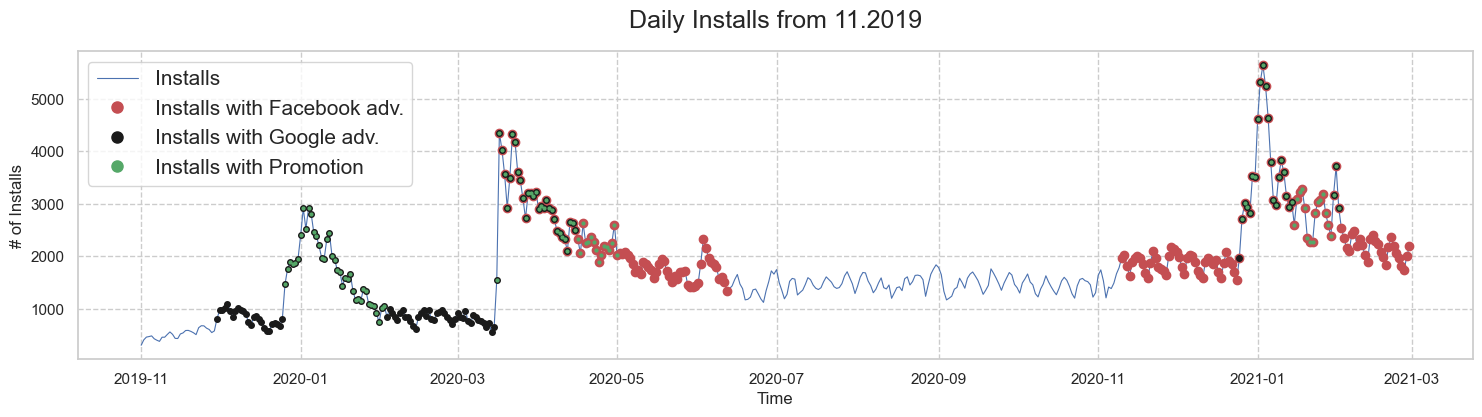

In [23]:
fig5, ax = plt.subplots(figsize = (18,4))

ax.set_title('Daily Installs from 11.2019', y=1.05, fontsize=18)

ax.plot(df_2019_11.date, df_2019_11.installs, lw=0.8, label='Installs')

ax.plot(df_2019_11[df_2019_11['spend_facebook'] > 0].date, df_2019_11[df_2019_11['spend_facebook'] > 0].installs, ls='none', marker='o', ms=6, color='r', label='Installs with Facebook adv.')
ax.plot(df_2019_11[df_2019_11['spend_google'] > 0].date, df_2019_11[df_2019_11['spend_google'] > 0].installs, ls='none', marker='o', ms=4, color='k', label='Installs with Google adv.')
ax.plot(df_2019_11[df_2019_11['promotion'] == 1].date, df_2019_11[df_2019_11['promotion'] == 1].installs, ls='none', marker='o', ms=2, color='g', label='Installs with Promotion')

ax.set(xlabel='Time', ylabel='# of Installs')
ax.grid(ls='--')
legend = ax.legend(fontsize=15)

for line in legend.get_lines():
    line.set_markersize(8)

plt.show()

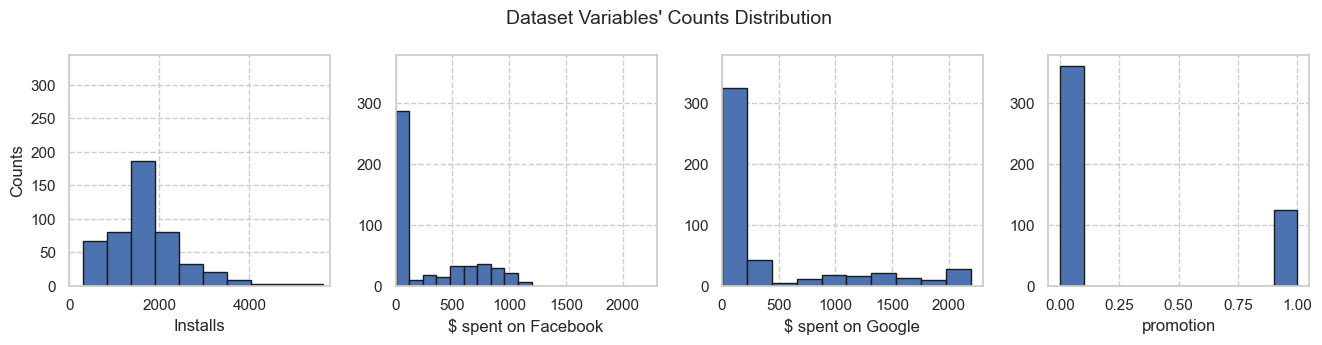

In [24]:
fig6, ax = plt.subplots(1, 4, figsize = (16,3))
plt.subplots_adjust(wspace=0.25)

fig6.suptitle("Dataset Variables' Counts Distribution", y=1.03, fontsize=14)

ax[0].hist(df_2019_11.installs, color='C0', edgecolor='k', zorder=2)
ax[0].set(xlabel='Installs', ylabel='Counts')
ax[0].axis([-0.5,5800,0,345])

ax[1].hist(df_2019_11['spend_facebook'], color='C0', edgecolor='k', zorder=2)
ax[1].set(xlabel='$ spent on Facebook', ylabel='')
ax[1].axis([-0.5,2300,0,380])

ax[2].hist(df_2019_11['spend_google'], color='C0', edgecolor='k', zorder=2)
ax[2].set(xlabel='$ spent on Google', ylabel='')
ax[2].axis([-0.5,2300,0,380])

ax[3].hist(df_2019_11.promotion, color='C0', edgecolor='k', zorder=2)
ax[3].set(xlabel='promotion', ylabel='')

for x in range(4):
    ax[x].grid(ls='--', zorder=0)

plt.show()

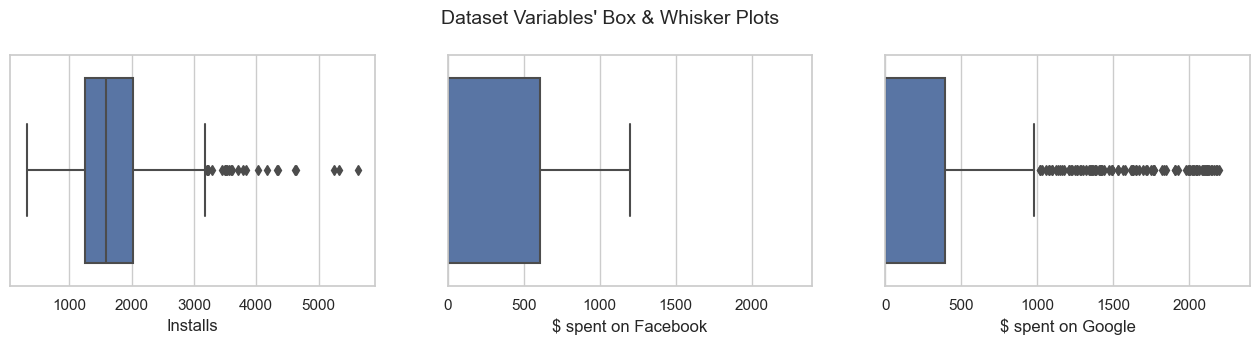

In [25]:
fig7, ax = plt.subplots(1, 3, figsize = (16,3))
plt.subplots_adjust(wspace=0.2)

fig7.suptitle("Dataset Variables' Box & Whisker Plots", y=1.03, fontsize=14)

sns.boxplot(df_2019_11.installs, orient='h', ax=ax[0])
ax[0].set(xlabel='Installs', ylabel='')

sns.boxplot(df_2019_11['spend_facebook'], orient='h', ax=ax[1])
ax[1].set(xlabel='$ spent on Facebook', ylabel='')
ax[1].axis([-0.5,2400,0.5,-0.5])

sns.boxplot(df_2019_11['spend_google'], orient='h', ax=ax[2])
ax[2].set(xlabel='$ spent on Google', ylabel='')
ax[2].axis([-0.5,2400,0.5,-0.5])

for x in range(3):
    ax[x].set_yticks([])
    ax[x].set_yticklabels([])

plt.show()

By cutting the dataset, we decreased the distributions skeweness and reduced the number of outliers

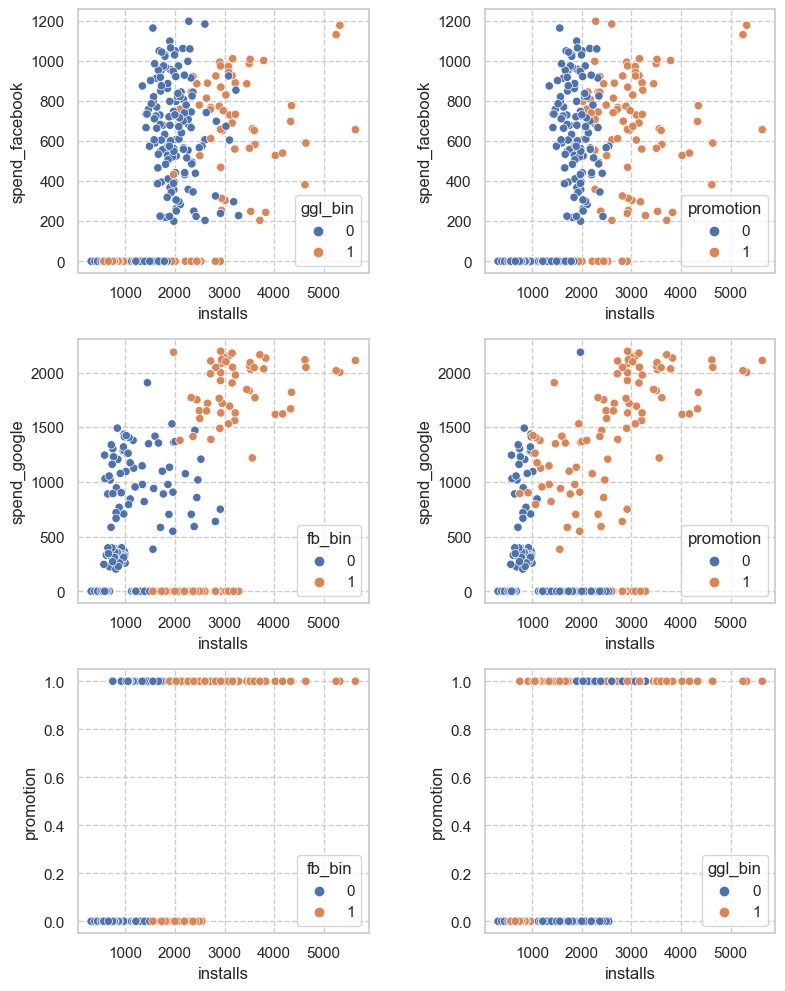

In [26]:
# Correlations between target and predictors

fig8, ax = plt.subplots(3, 2, figsize = (9,12))
plt.subplots_adjust(hspace=0.25, wspace=0.4)

sns.scatterplot(data=df_2019_11, x='installs', y='spend_facebook', hue='ggl_bin', ax=ax[0,0])
sns.scatterplot(data=df_2019_11, x='installs', y='spend_facebook', hue='promotion', ax=ax[0,1])
sns.scatterplot(data=df_2019_11, x='installs', y='spend_google', hue='fb_bin', ax=ax[1,0])
sns.scatterplot(data=df_2019_11, x='installs', y='spend_google', hue='promotion', ax=ax[1,1])
sns.scatterplot(data=df_2019_11, x='installs', y='promotion', hue='fb_bin', ax=ax[2,0])
sns.scatterplot(data=df_2019_11, x='installs', y='promotion', hue='ggl_bin', ax=ax[2,1])

for x in range(3):
    for y in range(2):
        ax[x,y].grid(ls='--', zorder=0)

plt.show()

From this plots, we note that the promotion feature has the most positive impact on the number of installations. Increasing the money spent on ggl and fb does not strongly relate to an increase of installation when the promotion is not taking place.

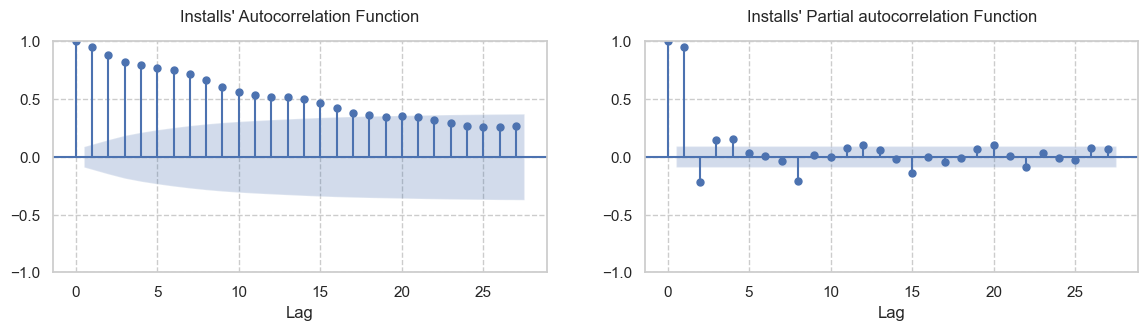

In [27]:
# Autocorrelation function and Partial Autocorrelation function plots

fig9, ax = plt.subplots(1, 2, figsize=(14,3))
plt.subplots_adjust(wspace=0.2)

plot_acf(df_2019_11.installs, ax=ax[0])
ax[0].set_title("Installs' Autocorrelation Function", y=1.05)

plot_pacf(df_2019_11.installs, ax=ax[1])
ax[1].set_title("Installs' Partial autocorrelation Function", y=1.05)

for x in range(2):
    ax[x].grid(ls='--')
    ax[x].set(xlabel='Lag', ylabel='')

plt.show()

We note that the # of installations are correlated to their own past values. The partial autocorrelation function suggests that 4 lags are enough to predict the future values.

The autocorrelation function tells us that the dataset is not stationary. Since we are not going to follow a deterministic approach, we don't need to engineer the dataset to make it stationary.

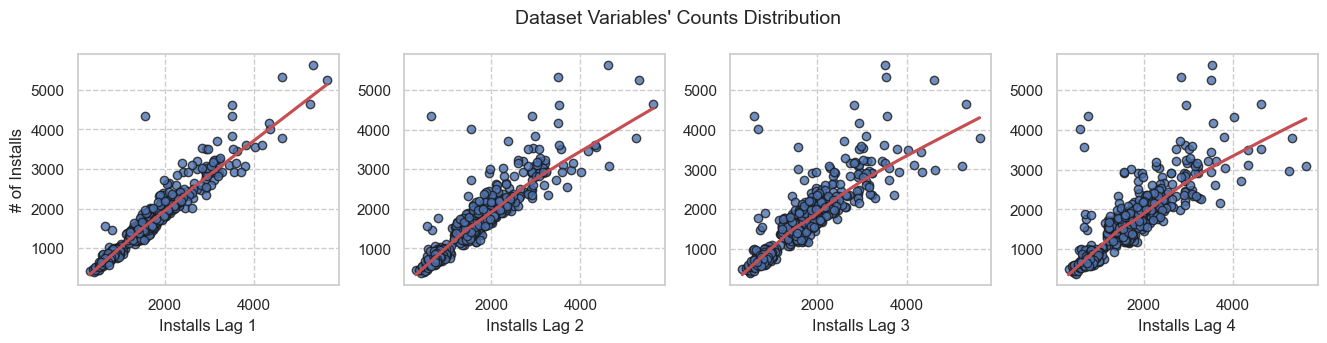

In [28]:
# Correlation between # of installations and its lagged values

fig10, ax = plt.subplots(1, 4, figsize = (16,3))
plt.subplots_adjust(wspace=0.25)

line_kws = dict(color='r')
scatter_kws = dict(color='C0', edgecolor='k')

fig10.suptitle("Dataset Variables' Counts Distribution", y=1.03, fontsize=14)

for x in range(4):
    sns.regplot(x=df_2019_11.installs.shift(x+1), y=df_2019_11.installs, lowess=True, ax=ax[x], scatter_kws=scatter_kws, line_kws=line_kws)
    ax[x].grid(ls='--', zorder=0)
    
ax[0].set(xlabel='Installs Lag 1', ylabel='# of Installs')
ax[1].set(xlabel='Installs Lag 2', ylabel='')
ax[2].set(xlabel='Installs Lag 3', ylabel='')
ax[3].set(xlabel='Installs Lag 4', ylabel='')

plt.show()

We note indeed a positive correlation between the # of installs and its lagged values.

Let's analyse now the data to check if there are any seasonality patterns.

In [29]:
# Seasonality analysis - creating a subset

idx_max = df_2019_11[df_2019_11['date'] < '2020-07-01']['installs'].idxmax()
idx_end = df_2019_11[df_2019_11['date'] == '2020-11-01'].index[0]

df_subset = df_2019_11.iloc[idx_max:idx_end+1].copy()

In [30]:
# Data decomposition in trend and seasonality

seasonalities = [7, 14, 31, 90]
seasonality_df = pd.DataFrame(columns=['period','mape','r2'])

for m in seasonalities:
    
    data_decomposed = STL(endog=df_subset.installs, period=m, robust=True).fit()
    model = data_decomposed.trend + data_decomposed.seasonal
    
    mape = (abs(df_subset.installs-model)/(df_subset.installs)).mean()
    r2 = r2_score(df_subset.installs, model)
    
    new_row = {'period':round(m,2), 'mape':round(mape,2), 'r2': round(r2,4)}
    if seasonality_df.empty:
        seasonality_df = pd.DataFrame([new_row])
    else:
        seasonality_df = pd.concat([seasonality_df, pd.DataFrame([new_row])], ignore_index=True)
    
seasonality_df

,period,mape,r2
0,7,0.04,0.9471
1,14,0.05,0.9292
2,31,0.07,0.8959
3,90,0.09,0.6815


A weekly seasonality coupled with a trend component gives good results as it can explain 94.7% of the target variable variance.

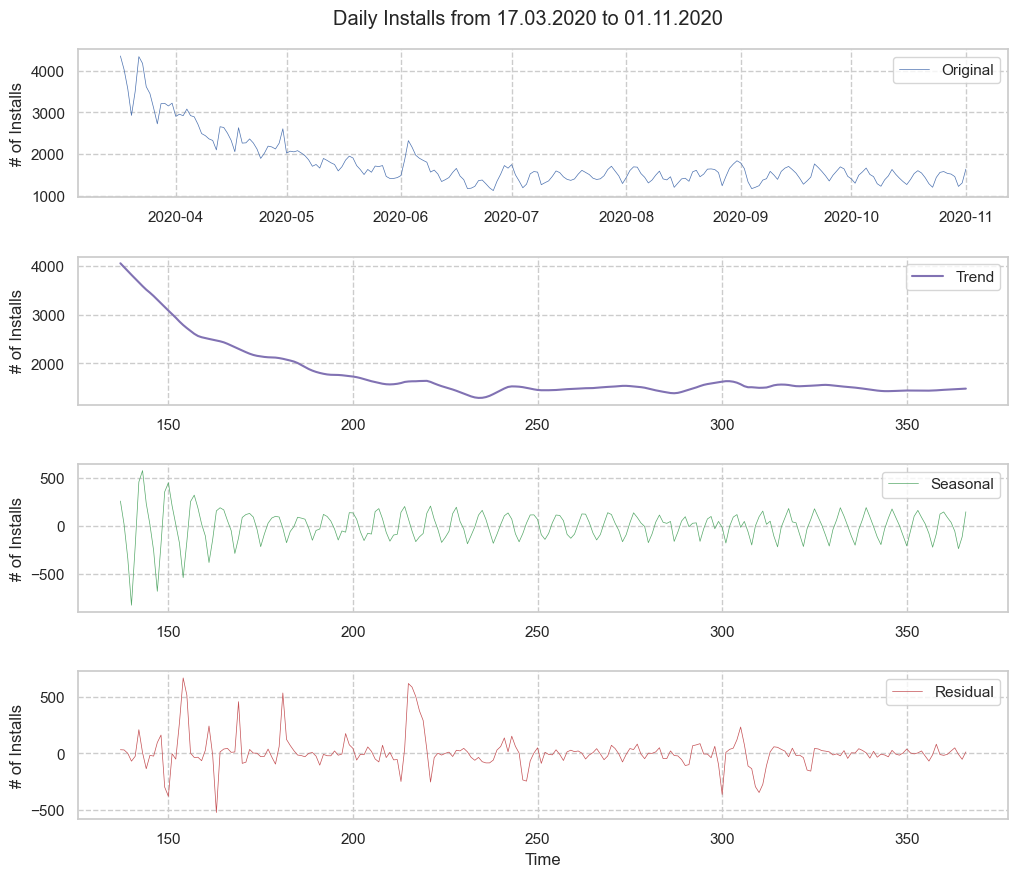

In [31]:
data_decomposed = STL(endog=df_subset.installs, period=7, robust=True).fit()

fig11, ax = plt.subplots(4, 1, figsize=(12,10))
plt.subplots_adjust(hspace=0.4)

fig11.suptitle('Daily Installs from 17.03.2020 to 01.11.2020', y=0.92)

ax[0].plot(df_subset.date, df_subset.installs, lw=0.5, label='Original')
ax[1].plot(data_decomposed.trend, label='Trend', color='m')
ax[2].plot(data_decomposed.seasonal, lw=0.5, label='Seasonal', color='g')
ax[3].plot(data_decomposed.resid, lw=0.5, label='Residual', color='r')

ax[3].set_xlabel('Time')
for x in range(4):
    ax[x].set_ylabel('# of Installs')
    ax[x].grid(ls='--')
    ax[x].legend()

In [32]:
weekly_seasonality = data_decomposed.seasonal.iloc[119:126]

We note that, after the beginning of a marketing campaign and the increase of the # of installations, a negative trend follows, coupled with a weekly seasonality. The daily # of installations after the marketing, stabilizes to a value that is larger than the one before the marketing campaign.

<a id='model'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Modeling <span style="float:right;"> 3. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

Since the daily # of installation are linearly correlated to its past values, I will train a linear regression model on a subset of the dataset and evaluate the model performance in the remaning istances. I will follow a backward elimination strategy: I train a model to all the predictors available, I will evaluate the model, I will train additional models in which I remove some predictors, and evaluate the simpler model to the more complex ones. 

In [33]:
def MultiVariate_Linear_Regression(df_train, df_test, unselected_predictors, save=False):
    
    X_train = df_train.drop(columns=unselected_predictors).copy()
    y_train = df_train['installs'].copy()
    
    X_test = df_test.drop(columns=unselected_predictors).copy()
    y_test = df_test['installs'].copy()
    
    selected_predictors = X_test.columns.tolist()
    
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)
    
    print('Predictors:\n', selected_predictors, '\n')
    print('Target: # of Installs', '\n')
    
    # Model fitting
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Model predictions
    
    X_forecast = X_train.copy()
    y_forecast = y_train.copy()
    
    for x in range(len(y_test)):
        y_forecast_i = math.ceil(model.predict(X_forecast.tail(1))[0])
        y_forecast.loc[len(y_forecast)] = y_forecast_i
        X_forecast.loc[len(X_forecast)] = [X_test[col].iloc[x] for col in selected_predictors]
        
    # Model evaluation
    
    r2 = round(r2_score(y_test, y_forecast[y_test.index[0]:]), 4)
    mape = round((abs(y_test - y_forecast[y_test.index[0]:]) / y_test).mean(), 4)
    print("Model metrics:")
    print("R2 Score on Test Set: ", r2)
    print("MAPE on Test Set: ", mape, '\n')
    
    fig, ax = plt.subplots(1, 2, figsize=(15,3), gridspec_kw={'width_ratios': [1.5, 1]})
    ax[0].plot(y_train, color='k', label='Original Data')
    ax[0].plot(y_test, color='k')
    ax[0].plot(y_forecast[y_test.index[0]:], color='b', label='Model')
    ax[0].set(xlabel='Days', ylabel='# of Installs')
    legend = ax[0].legend(fontsize=12, loc=2)
    
    ax[1].plot(y_test, color='k')
    ax[1].plot(y_forecast[y_test.index[0]:], color='b')
    ax[1].set(xlabel='Days', ylabel='')
    
    plt.show()
    
    if save == True:
        fig.savefig('Results/Best_Model_Training.jpg', dpi=250, bbox_inches='tight')
    
    return r2, mape, model.coef_, model.intercept_

In [34]:
# Train - test split

df_train = df_2019_11[df_2019_11.date < '2020-10-01'].copy()
df_test = df_2019_11[df_2019_11.date >= '2020-10-01'].copy()

In the first step, all available predictors are selected, except for 'date', 'fb_bin', 'ggl_bin', which are redundant.

'installs' is of course the target variable.

Predictors:
 ['n_day', 'spend_facebook', 'spend_google', 'promotion', 'day', 'weekday', 'is_weekend', 'fb_prom', 'ggl_prom', 'fb_ggl_prom', 'fb_lag1', 'fb_lag2', 'fb_lag3', 'fb_lag4', 'ggl_lag1', 'ggl_lag2', 'ggl_lag3', 'ggl_lag4', 'installs_lag1', 'installs_lag2', 'installs_lag3', 'installs_lag4'] 

Target: # of Installs 

Model metrics:
R2 Score on Test Set:  0.7049
MAPE on Test Set:  0.1411 



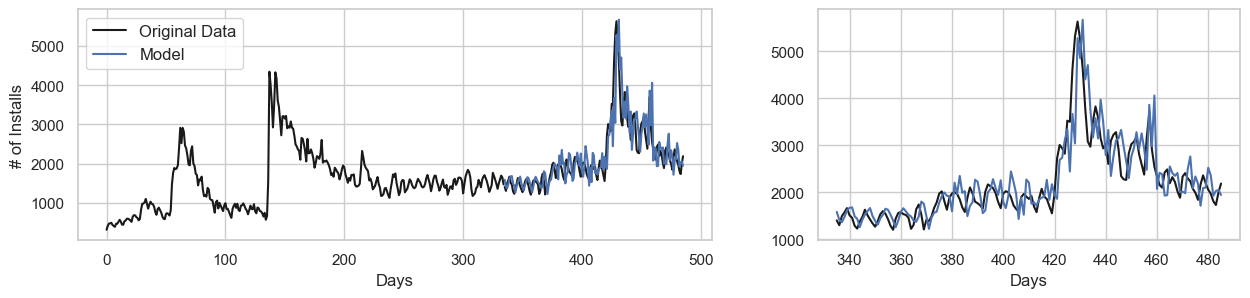

In [35]:
unselected_predictors = ['date', 'installs', 'fb_bin', 'ggl_bin']

model_1 = MultiVariate_Linear_Regression(df_train, df_test, unselected_predictors)

Predictors:
 ['n_day', 'spend_facebook', 'spend_google', 'promotion', 'day', 'weekday', 'fb_prom', 'ggl_prom', 'fb_ggl_prom', 'fb_lag1', 'fb_lag2', 'fb_lag3', 'fb_lag4', 'ggl_lag1', 'ggl_lag2', 'ggl_lag3', 'ggl_lag4', 'installs_lag1', 'installs_lag2', 'installs_lag3', 'installs_lag4'] 

Target: # of Installs 

Model metrics:
R2 Score on Test Set:  0.7122
MAPE on Test Set:  0.1445 



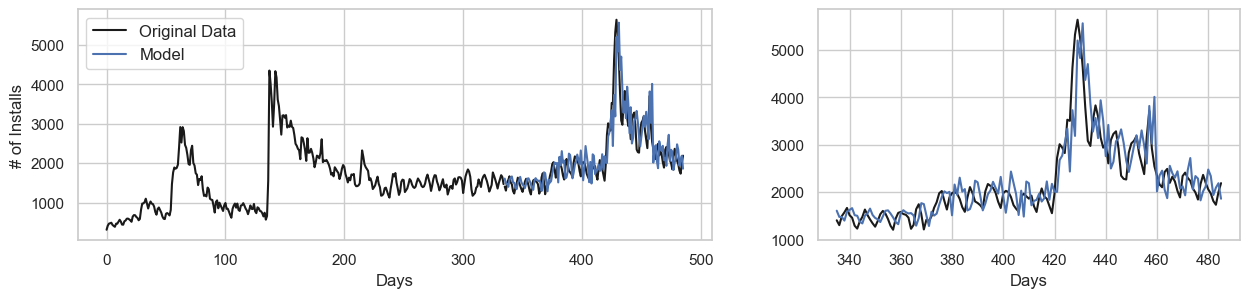

In [36]:
# Backward elimination strategy - Removing is_weekend

unselected_predictors = ['date', 'installs','fb_bin', 'ggl_bin', 'is_weekend']

model_2 = MultiVariate_Linear_Regression(df_train, df_test, unselected_predictors)

Predictors:
 ['n_day', 'spend_facebook', 'spend_google', 'promotion', 'weekday', 'fb_prom', 'ggl_prom', 'fb_ggl_prom', 'fb_lag1', 'fb_lag2', 'fb_lag3', 'fb_lag4', 'ggl_lag1', 'ggl_lag2', 'ggl_lag3', 'ggl_lag4', 'installs_lag1', 'installs_lag2', 'installs_lag3', 'installs_lag4'] 

Target: # of Installs 

Model metrics:
R2 Score on Test Set:  0.7125
MAPE on Test Set:  0.1444 



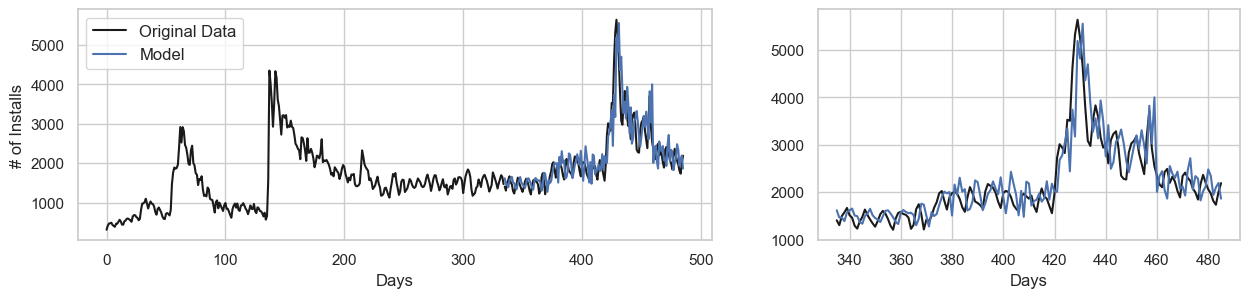

In [37]:
# Backward elimination strategy - Removing is_weekend

unselected_predictors = ['date', 'installs','fb_bin', 'ggl_bin', 'is_weekend', 'day']

model_3 = MultiVariate_Linear_Regression(df_train, df_test, unselected_predictors)

Predictors:
 ['n_day', 'spend_facebook', 'spend_google', 'promotion', 'fb_prom', 'ggl_prom', 'fb_ggl_prom', 'fb_lag1', 'fb_lag2', 'fb_lag3', 'fb_lag4', 'ggl_lag1', 'ggl_lag2', 'ggl_lag3', 'ggl_lag4', 'installs_lag1', 'installs_lag2', 'installs_lag3', 'installs_lag4'] 

Target: # of Installs 

Model metrics:
R2 Score on Test Set:  0.7148
MAPE on Test Set:  0.1434 



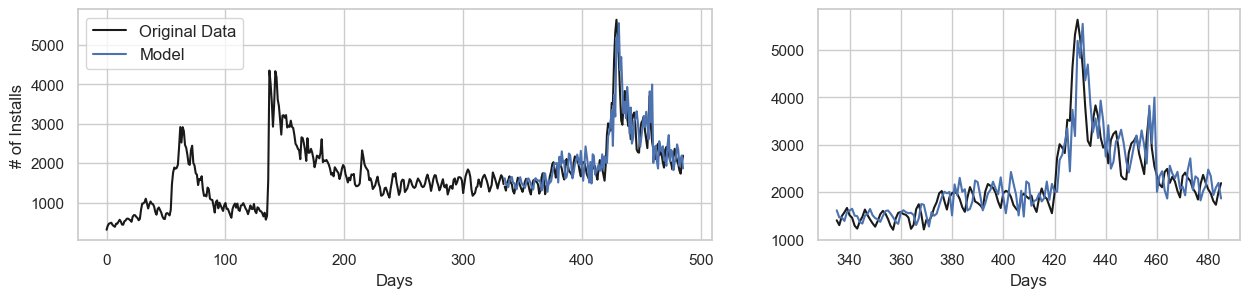

In [38]:
# Backward elimination strategy - Removing weekday

unselected_predictors = ['date', 'installs','fb_bin', 'ggl_bin', 'is_weekend', 'day', 'weekday']

model_4 = MultiVariate_Linear_Regression(df_train, df_test, unselected_predictors)

Predictors:
 ['n_day', 'spend_facebook', 'spend_google', 'promotion', 'fb_prom', 'ggl_prom', 'fb_ggl_prom', 'fb_lag1', 'fb_lag2', 'fb_lag3', 'ggl_lag1', 'ggl_lag2', 'ggl_lag3', 'installs_lag1', 'installs_lag2', 'installs_lag3'] 

Target: # of Installs 

Model metrics:
R2 Score on Test Set:  0.712
MAPE on Test Set:  0.1458 



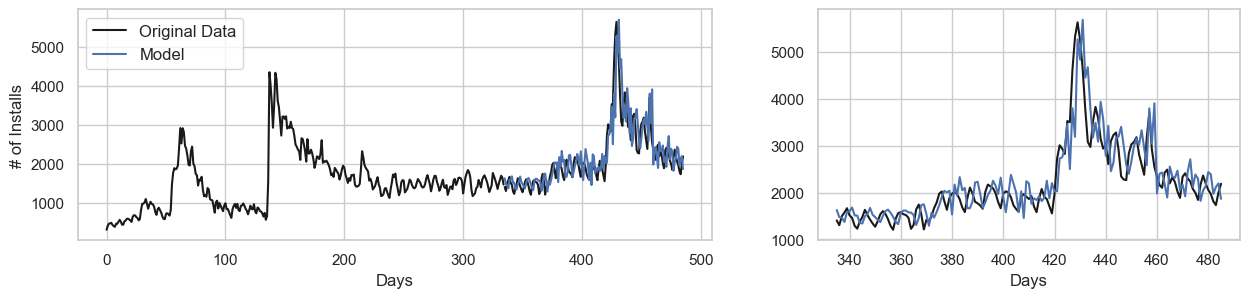

In [39]:
# Backward elimination strategy - Removing lag4

unselected_predictors = ['date', 'installs','fb_bin', 'ggl_bin', 'is_weekend', 'day', 'weekday', 'fb_lag4', 'ggl_lag4', 'installs_lag4']

model_5 = MultiVariate_Linear_Regression(df_train, df_test, unselected_predictors)

By removing the lag4 variables we are worsening the model, so we will keep them.

Predictors:
 ['n_day', 'spend_facebook', 'spend_google', 'promotion', 'fb_ggl_prom', 'fb_lag1', 'fb_lag2', 'fb_lag3', 'fb_lag4', 'ggl_lag1', 'ggl_lag2', 'ggl_lag3', 'ggl_lag4', 'installs_lag1', 'installs_lag2', 'installs_lag3', 'installs_lag4'] 

Target: # of Installs 

Model metrics:
R2 Score on Test Set:  0.7208
MAPE on Test Set:  0.1413 



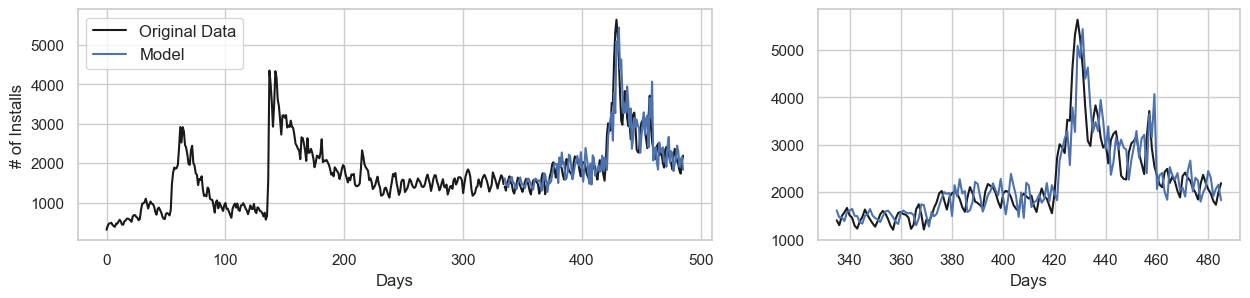

In [40]:
# Backward elimination strategy - Removing cross variables

unselected_predictors = ['date', 'installs','fb_bin', 'ggl_bin', 'is_weekend', 'day', 'weekday', 'fb_prom', 'ggl_prom']

model_6 = MultiVariate_Linear_Regression(df_train, df_test, unselected_predictors, save=True)

From these tests, we note that the best model (# 6) can explain 72.1% of the test dataset variance and it produces predictions which differ on average by 14.1% from the actual values. The following cell lists the regression coefficients and the intercept.

In [41]:
print('Model coefficients:\n', model_6[2], '\n\n Model intercept:\n', model_6[3])

Model coefficients:
 [ 6.11979277e-01  5.36784397e-01  1.99519604e-01  2.32075641e+02
  1.38143640e-04 -3.47864500e-01 -2.25583076e-02 -1.40002214e-01
  6.38192949e-02 -1.23393053e-01 -3.41381887e-02 -1.26832564e-02
 -6.93095488e-02  9.55316634e-01 -2.52778232e-01 -6.24713242e-02
  1.36633172e-01] 

 Model intercept:
 159.99807175373962


<a id='forecast'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Final Model & Forecasting  <span style="float:right;"> 4 </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

I am going to train now a model on the whole dataset, and on the predictors that gave the best result in the previous stage. I will then forecast the daily # of installations for the next 4 weeks with different amounts of funds allocated to the different media channels.

In [42]:
# Selecting model #6 features

unselected_predictors = ['date', 'installs','fb_bin', 'ggl_bin', 'is_weekend', 'day', 'weekday', 'fb_prom', 'ggl_prom']

X = df_2019_11.drop(columns=unselected_predictors).copy()
y = df_2019_11['installs'].copy()

# Model fitting

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [43]:
# Saving the model

#with open('MMM_LinearRegressor.pkl', 'wb') as file:
#    pickle.dump(model, file)

In [44]:
def Forecasting(X_forecast, y_forecast, money_on_adv_A, money_on_adv_B, promototed, weeks, weekly_seasonality):
    
    for next_day in range(7*weeks):
        y_forecast_i = math.ceil(model.predict(X_forecast.tail(1)))
        y_forecast.loc[len(y_forecast)] = y_forecast_i
        X_forecast.loc[len(X_forecast)] = [X_forecast['n_day'].iloc[-1]+1, money_on_adv_A, money_on_adv_B, promototed, promototed*money_on_adv_A*money_on_adv_B, X_forecast['spend_facebook'].iloc[-1], X_forecast['fb_lag1'].iloc[-1], X_forecast['fb_lag2'].iloc[-1], X_forecast['fb_lag3'].iloc[-1], X_forecast['spend_google'].iloc[-1], X_forecast['ggl_lag1'].iloc[-1], X_forecast['ggl_lag2'].iloc[-1], X_forecast['ggl_lag3'].iloc[-1], y_forecast_i, X_forecast['installs_lag1'].iloc[-1], X_forecast['installs_lag2'].iloc[-1], X_forecast['installs_lag3'].iloc[-1]]

    weekly_seasonality = pd.concat([weekly_seasonality] * weeks, ignore_index=True)
    tail_y_forecast = y_forecast.tail(7*weeks)
    reindexed_weekly_seasonality = pd.Series(weekly_seasonality.values, index=tail_y_forecast.index)
    y_forecast.iloc[-7*weeks:] = tail_y_forecast.add(reindexed_weekly_seasonality)

In [45]:
# Model forecast

X_forecast = X.copy()
y_forecast = y.copy()

In [46]:
# Money on FB = 500$, Money on Google = 1000$, promoted = Yes, weeks = 1

Forecasting(X_forecast, y_forecast, 500, 2000, 1, 1, weekly_seasonality)

In [47]:
# Money on FB = 1000$, Money on Google = 500$, promoted = Yes, weeks = 1

Forecasting(X_forecast, y_forecast, 2000, 500, 1, 1, weekly_seasonality)

In [48]:
# Money on FB = 1000$, Money on Google = 500$, promoted = No, weeks = 1

Forecasting(X_forecast, y_forecast, 2000, 500, 0, 1, weekly_seasonality)

In [49]:
# Money on FB = 500$, Money on Google = 1000$, promoted = No, weeks = 1

Forecasting(X_forecast, y_forecast, 500, 2000, 0, 1, weekly_seasonality)

In [50]:
# Money on FB = 0$, Money on Google = 0$, promoted = No, weeks = 4

Forecasting(X_forecast, y_forecast, 0, 0, 0, 4, weekly_seasonality)

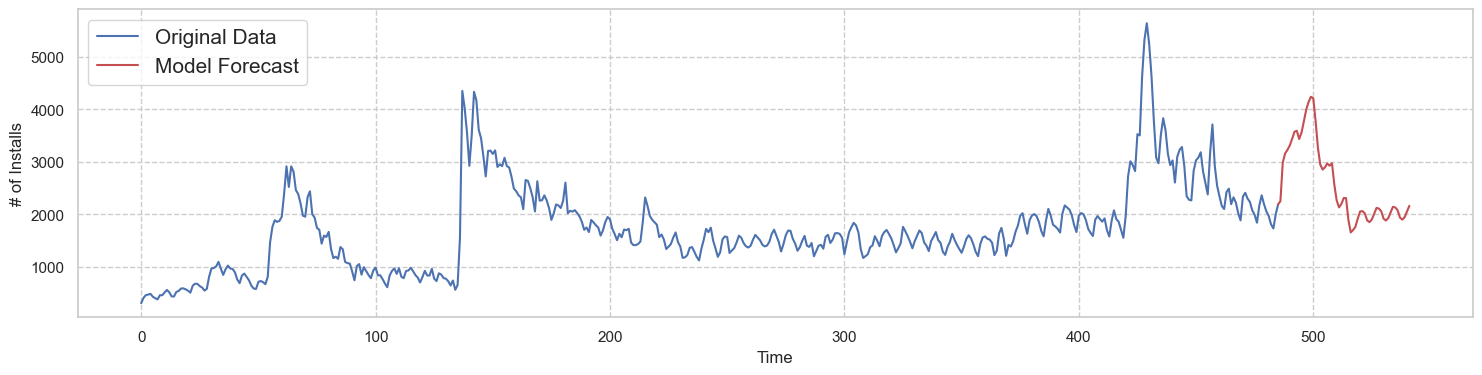

In [51]:
fig12, ax = plt.subplots(figsize = (18,4))

ax.plot(y, label='Original Data')
ax.plot(y_forecast[y.index[-1]:], color='r', label='Model Forecast')

ax.set(xlabel='Time', ylabel='# of Installs')
ax.grid(ls='--')
legend = ax.legend(fontsize=15, loc=2)

plt.show()

In [52]:
fig12.savefig('Results/Model_Forecast.jpg', dpi=250, bbox_inches='tight')

In [53]:
# Installations due to the campaign

prior_campaign_daily_installations = round(y.iloc[380:420].mean(), 0)

post_campaign_total_installations = round(y_forecast[y.index[-1]:].sum(), 0)

new_users_by_campaign = post_campaign_total_installations - prior_campaign_daily_installations *len(y_forecast[y.index[-1]:])

new_users_by_campaign

40380.0

Thanks to the marketing campaign, the app was installed 40380 times, installations that were not expected if the campaign was not taking place.

In [54]:
# Increase of daily installations due to the campaign

post_campaign_daily_installations = round(y_forecast.iloc[-7*3:].mean(), 0)

round((post_campaign_daily_installations - prior_campaign_daily_installations) / prior_campaign_daily_installations *100, 2)

7.72

Thanks to the marketing campaign, the app daily installations increased by 7.7% for a total of 70.000$ spent in 4 weeks.

<a id='end'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Results & Next Steps  <span style="float:right;"> 5. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

#### Key Insights:

1. When the promotion takes place, the # of installations greatly increases.
2. Follows a slow decay and a stabilization to a # of installations larger than the one present before the promotion took place.
3. The # of installations shows a weekly seasonality.
4. Increasing the money spent on Google or Facebook does not strongly relate to an increase of installations when the promotion is not taking place.
5. There is a positive correlation between the # of installations and its lagged values. A linear regression model was therefore built.
6. The best model can explain 72.1% of the test dataset variance and it produces predictions which differ on average by 14.1% from the actual values.
7. Thanks to the marketing campaign, the app was installed 40380 additional times.
8. Thanks to the marketing campaign, the app daily installations increased by 7.7% for a total of 70.000$ spent in 4 weeks.

#### Next Steps:

1. Account for more lagged predictors, up to lag7 or lag30.
2. Retrieve additional predictors that may affect the # of installations.
3. Test the performance of a Neural Network model.
4. Increase the historical time span of the dataset.